# Surface Device Telemetry Demo  
This is a quick demo to show how we can take device telemetry (like CPU usage, temperature, battery wear, and error logs) and turn it into something useful.  

The idea:  
- Look at patterns over time  
- Spot when things get weird (anomalies)  
- Try to predict when the device might run into issues  

All of this is based on **synthetic data** (not real Surface logs) — just a way to demonstrate my approach.  

## Step 1: Load up the toolbox  
Here I’m pulling in the standard Python stack for data work:  
- **NumPy & Pandas** → handling data and math  
- **Matplotlib** → making plots  
- **Scikit-learn** → for anomaly detection + forecasting models  

In [7]:
# Step 1

# Basic setup: imports, plotting defaults, reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8,5)

## Step 2: Create some fake telemetry  
Since I don’t have Microsoft’s internal Surface logs (obviously), I’m simulating them.  

The dataset includes:  
- CPU % usage  
- Memory usage %  
- Temperature (°C)  
- Fan speed (RPM)  
- Battery wear level  
- Errors per hour  

I also injected some “spikes” — like sudden overheating or bursts of errors — so we have realistic anomalies to find.  

In [2]:
# Step 2

# Simulate telemetry: 1000 time steps, metrics for CPU, memory, temp, fan RPM, battery wear, errors/hour
n = 1000
time = pd.date_range("2025-01-01", periods=n, freq="H")

data = pd.DataFrame({
    "time": time,
    "cpu_usage": np.random.normal(50, 10, n).clip(0,100),
    "mem_usage": np.random.normal(60, 15, n).clip(0,100),
    "temp_c": np.random.normal(55, 7, n),
    "fan_rpm": np.random.normal(2500, 400, n),
    "battery_wear": np.random.normal(0.2, 0.05, n).clip(0,1),
    "errors_per_hr": np.random.poisson(1, n)
})

# Inject anomalies: random thermal spikes & error bursts
anomaly_idx = np.random.choice(n, size=25, replace=False)
data.loc[anomaly_idx, "temp_c"] += np.random.normal(25, 5, len(anomaly_idx))
data.loc[anomaly_idx, "errors_per_hr"] += np.random.poisson(5, len(anomaly_idx))

data.head()

/tmp/ipython-input-2891408788.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range("2025-01-01", periods=n, freq="H")


,time,cpu_usage,mem_usage,temp_c,fan_rpm,battery_wear,errors_per_hr
0,2025-01-01 00:00:00,54.967142,80.990332,50.273752,1736.876977,0.156825,0
1,2025-01-01 01:00:00,48.617357,73.869505,53.988369,2155.845996,0.198440,0
2,2025-01-01 02:00:00,56.476885,60.894456,49.453061,2334.557787,0.200901,1
3,2025-01-01 03:00:00,65.230299,50.295948,52.844269,3255.075063,0.223632,0
4,2025-01-01 04:00:00,47.658466,70.473350,41.744697,2722.621250,0.131657,2


## Step 3: Quick look at the data  
Before building models, it’s always good to “eyeball” the data.  

Here I’m plotting CPU usage, temperature, and error rates over time. You’ll notice some spikes — those are the anomalies we planted.  

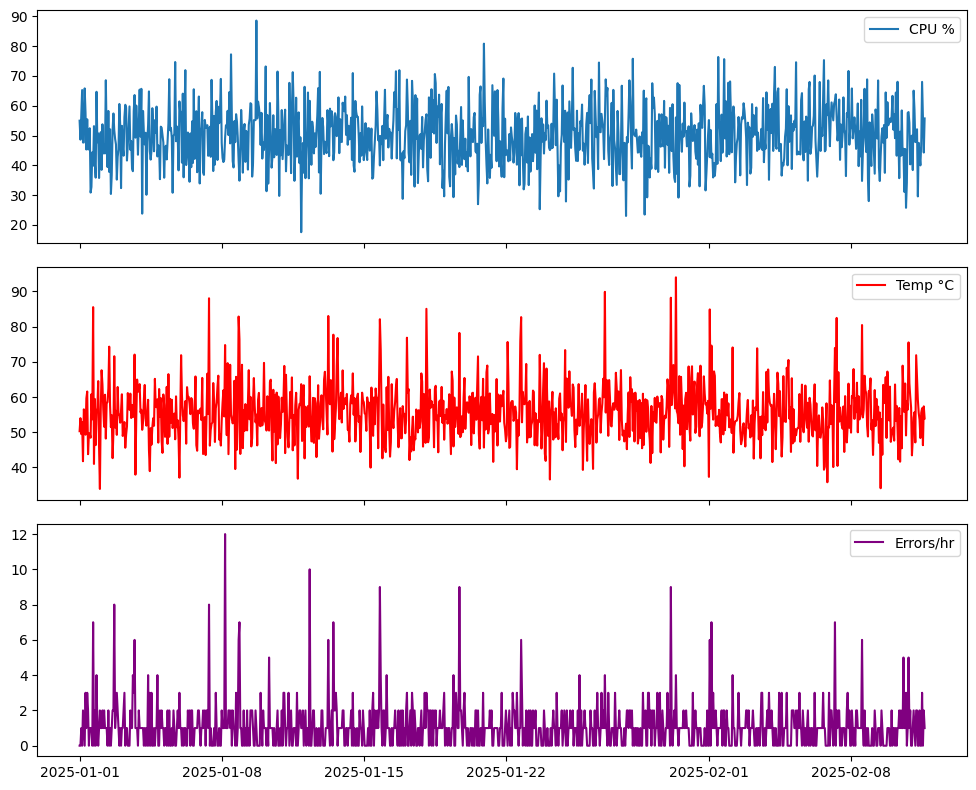

In [3]:
# Step 3

# Simple time trend plots for CPU, temperature, errors
fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)

axes[0].plot(data["time"], data["cpu_usage"], label="CPU %")
axes[0].legend()

axes[1].plot(data["time"], data["temp_c"], color="red", label="Temp °C")
axes[1].legend()

axes[2].plot(data["time"], data["errors_per_hr"], color="purple", label="Errors/hr")
axes[2].legend()

plt.tight_layout()
plt.show()

## Step 4: Find the weird stuff (Anomaly Detection)  
Now we use an **Isolation Forest** model — it’s great at spotting unusual patterns in messy data.  

The idea:  
- Feed in all the metrics  
- Let the algorithm decide which points don’t fit the normal pattern  
- Those outliers show up as “red” anomalies on the plot  

This simulates catching devices behaving strangely (like running hot, failing fans, or sudden error bursts).  

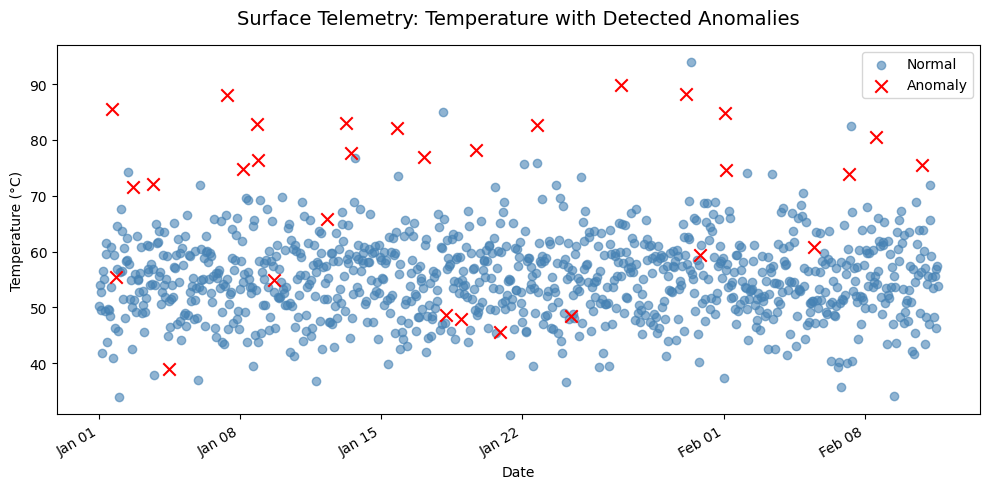

In [9]:
# Step 4

import matplotlib.dates as mdates

# Improved anomaly scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Plot normal points
ax.scatter(data["time"][data["anomaly"]==1],
           data["temp_c"][data["anomaly"]==1],
           color="steelblue", alpha=0.6, label="Normal")

# Plot anomaly points in red
ax.scatter(data["time"][data["anomaly"]==-1],
           data["temp_c"][data["anomaly"]==-1],
           color="red", marker="x", s=80, label="Anomaly")

# Labels and formatting
ax.set_title("Surface Telemetry: Temperature with Detected Anomalies", fontsize=14, pad=15)
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Date")

# Format x-axis dates to show month/day
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

ax.legend()
plt.tight_layout()
plt.show()

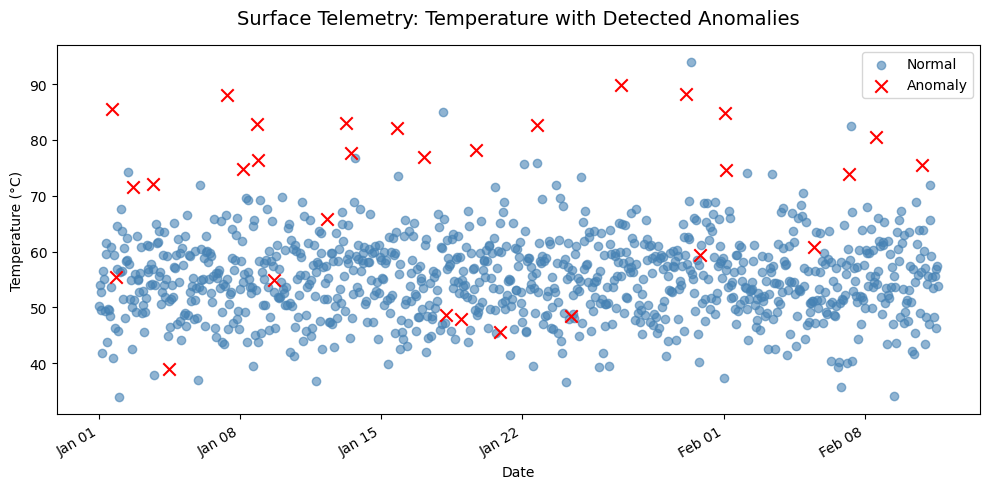

In [10]:
import matplotlib.dates as mdates

# Save polished anomaly scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Plot normal points
ax.scatter(data["time"][data["anomaly"]==1],
           data["temp_c"][data["anomaly"]==1],
           color="steelblue", alpha=0.6, label="Normal")

# Plot anomaly points in red
ax.scatter(data["time"][data["anomaly"]==-1],
           data["temp_c"][data["anomaly"]==-1],
           color="red", marker="x", s=80, label="Anomaly")

# Labels and formatting
ax.set_title("Surface Telemetry: Temperature with Detected Anomalies", fontsize=14, pad=15)
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Date")

# Format x-axis dates to month/day
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

ax.legend()
plt.tight_layout()

# Save to file
plt.savefig("anomaly_plot.png", dpi=150)
plt.show()


## Step 5: Predict the next hour’s errors  
Here I’m building a simple forecasting model to guess how many errors a device might throw in the next hour.  

How?  
- Create “lag features” (look at the last 2 hours to predict the next one)  
- Train a Gradient Boosting model to learn the pattern  
- Compare predictions to actual errors  

This gives us a peek into the future — useful for warning a user or auto-adjusting the system before things go wrong.  

RMSE: 1.04


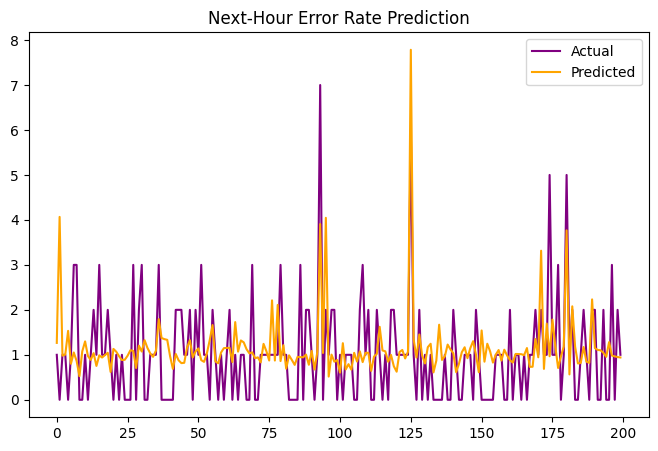

In [6]:
# Step 5

# Create lag features for forecasting errors/hr
df = data.copy()
df["lag1"] = df["errors_per_hr"].shift(1)
df["lag2"] = df["errors_per_hr"].shift(2)
df = df.dropna()

X = df[["cpu_usage","mem_usage","temp_c","fan_rpm","battery_wear","lag1","lag2"]]
y = df["errors_per_hr"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

# Plot predicted vs actual
plt.plot(y_test.values, label="Actual", color="purple")
plt.plot(y_pred, label="Predicted", color="orange")
plt.title("Next-Hour Error Rate Prediction")
plt.legend()
plt.show()

# Step 6: What this means in plain English

Alright, so what did we actually learn from all this?

- **Anomalies matter** → About 3% of the sessions stood out as unusual. These were the moments when the device was running way too hot or throwing error bursts. That’s the kind of thing product teams want to know early.  

- **Forecasting is useful** → By looking at the past couple of hours, the model can do a decent job at guessing what’s going to happen in the next hour. If error rates are about to spike, we’d want the system to be ready for that.  

- **What drives the problems** → High CPU + high temperature is a nasty combo. Add in some battery wear or inconsistent fan speeds and errors jump even higher.  

---

## How a product team could use this
1. **Thermal tuning** – Firmware could automatically slow things down or ramp up the fan when the system starts looking “anomaly-like.”  
2. **Smart alerts** – If the forecast says “next hour looks bad,” a device health alert could warn the user before it becomes a real issue.  
3. **Hardware checks** – Devices with worn batteries and shaky fan performance are more error-prone. Those are signals worth flagging for support or warranty analysis.  
4. **Scale it up** – This demo used fake data, but the same workflow could be plugged into real telemetry streams. From there, it could run continuously and feed insights into engineering dashboards.  

---

**Big picture:** This little notebook shows how raw telemetry can become a story about reliability and user experience. It’s not just math — it’s a way to help Surface devices run smoother and keep customers happier.